In [2]:
import os
from pathlib import Path
import pandas as pd

# Get the project root directory
project_root = Path(os.getcwd()).parent
config_path = project_root / "configs"

from electricity_forecast.config_and_logging import load_config_hydra
config = load_config_hydra("config_test.yaml", config_path=config_path)

train_df = pd.read_csv(project_root / "data" / "data_raw" / "df_train.csv")
test_df = pd.read_csv(project_root / "data" / "data_raw" / "df_test.csv")

# Test model object and outcomes

In [2]:
import json
import joblib
from google.cloud import storage

# Your project configuration
GCP_PROJECT_ID = "energy-forecast-467113"
MODEL_BUCKET = "forecast_bucket_inference"
SERVICE_ACCOUNT_EMAIL = "cloud-run-sa-energy-forecast-i@energy-forecast-467113.iam.gserviceaccount.com"
CONFIG_NAME = "config_cv.yaml"

def load_model():
    """Load the latest production model from GCS (via latest/model_info.json)"""
    # Client will automatically use credentials from environment
    client = storage.Client(project=GCP_PROJECT_ID)
    bucket = client.bucket(MODEL_BUCKET)

    # Step 1: Download model_info.json to find latest model
    info_blob = bucket.blob("models/energy-forecast-model/latest/model_info.json")
    info_blob.download_to_filename("latest_model_info.json")

    with open("latest_model_info.json", "r") as f:
        model_info = json.load(f)

    # Step 2: Extract model path
    latest_model_gcs_path = model_info["latest_model"]  # "gs://bucket/..."
    # Convert to blob path
    blob_path = latest_model_gcs_path.replace(f"gs://{MODEL_BUCKET}/", "")

    # Step 3: Download and load model
    model_blob = bucket.blob(blob_path)
    model_blob.download_to_filename("latest_model.joblib")

    return joblib.load("latest_model.joblib")

In [ ]:
pipeline = load_model()

In [3]:
import joblib
pipeline = joblib.load(project_root / "saved_models" / "combined_model.joblib")

In [4]:
pipeline.steps

[('preprocessing',
  Pipeline(steps=[('preprocessor',
                   WeatherDataPreprocessor(add_time_dummies='cyclical')),
                  ('imputer', TimeAwareKNNImputer(column='Valencia_pressure'))])),
 ('model',
  ExtraTreesRegressor(max_depth=5, min_samples_split=5, n_estimators=50))]

## Test feature importance

In [5]:
preprocessor = pipeline.named_steps['preprocessing']
preprocessor

,steps,"[('preprocessor', ...), ('imputer', ...)]"
,transform_input,None
,memory,None
,verbose,False
,freq,'3h'
,add_time_dummies,'cyclical'
,column,'Valencia_pressure'
,n_neighbors,5
,add_time_dummies,'cyclical'


In [6]:
preprocessor.named_steps

{'preprocessor': WeatherDataPreprocessor(add_time_dummies='cyclical'),
 'imputer': TimeAwareKNNImputer(column='Valencia_pressure')}

In [7]:
len(preprocessor.named_steps['preprocessor'].get_feature_names_out(train_df.columns))

53

In [8]:
X_transformed = preprocessor.transform(train_df)
print("Shape:", X_transformed.shape)
print("Columns in transformed data (if DataFrame):")
if isinstance(X_transformed, pd.DataFrame):
    print(X_transformed.columns.tolist())

Shape: (8763, 53)
Columns in transformed data (if DataFrame):
['Madrid_wind_speed', 'Valencia_wind_deg', 'Bilbao_rain_1h', 'Valencia_wind_speed', 'Seville_humidity', 'Madrid_humidity', 'Bilbao_clouds_all', 'Bilbao_wind_speed', 'Seville_clouds_all', 'Bilbao_wind_deg', 'Barcelona_wind_speed', 'Barcelona_wind_deg', 'Madrid_clouds_all', 'Seville_wind_speed', 'Barcelona_rain_1h', 'Seville_pressure', 'Seville_rain_1h', 'Bilbao_snow_3h', 'Barcelona_pressure', 'Seville_rain_3h', 'Madrid_rain_1h', 'Barcelona_rain_3h', 'Valencia_snow_3h', 'Madrid_weather_id', 'Barcelona_weather_id', 'Bilbao_pressure', 'Seville_weather_id', 'Valencia_pressure', 'Seville_temp_max', 'Madrid_pressure', 'Valencia_temp_max', 'Valencia_temp', 'Bilbao_weather_id', 'Seville_temp', 'Valencia_humidity', 'Valencia_temp_min', 'Barcelona_temp_max', 'Madrid_temp_max', 'Barcelona_temp', 'Bilbao_temp_min', 'Bilbao_temp', 'Barcelona_temp_min', 'Bilbao_temp_max', 'Seville_temp_min', 'Madrid_temp', 'Madrid_temp_min', 'hour_sin', 'h

c:\Users\lackerman008\Electricity Shortfall Challenge\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [10]:
# What's in expected but NOT in actual?

expected = preprocessor.named_steps['preprocessor'].get_feature_names_out(train_df.columns)
actual = X_transformed.columns.tolist() if isinstance(X_transformed, pd.DataFrame) else []
missing = set(expected) - set(actual)
print("Missing (expected but not in actual):", missing)

# What's in actual but NOT in expected?
extra = set(actual) - set(expected)
print("Extra (in actual but not expected):", extra)

Missing (expected but not in actual): set()
Extra (in actual but not expected): set()


In [11]:
X_transformed = preprocessor.transform(test_df)
print("Shape:", X_transformed.shape)
print("Columns in transformed data (if DataFrame):")
if isinstance(X_transformed, pd.DataFrame):
    print(X_transformed.columns.tolist())

Shape: (2920, 53)
Columns in transformed data (if DataFrame):
['Madrid_wind_speed', 'Valencia_wind_deg', 'Bilbao_rain_1h', 'Valencia_wind_speed', 'Seville_humidity', 'Madrid_humidity', 'Bilbao_clouds_all', 'Bilbao_wind_speed', 'Seville_clouds_all', 'Bilbao_wind_deg', 'Barcelona_wind_speed', 'Barcelona_wind_deg', 'Madrid_clouds_all', 'Seville_wind_speed', 'Barcelona_rain_1h', 'Seville_pressure', 'Seville_rain_1h', 'Bilbao_snow_3h', 'Barcelona_pressure', 'Seville_rain_3h', 'Madrid_rain_1h', 'Barcelona_rain_3h', 'Valencia_snow_3h', 'Madrid_weather_id', 'Barcelona_weather_id', 'Bilbao_pressure', 'Seville_weather_id', 'Valencia_pressure', 'Seville_temp_max', 'Madrid_pressure', 'Valencia_temp_max', 'Valencia_temp', 'Bilbao_weather_id', 'Seville_temp', 'Valencia_humidity', 'Valencia_temp_min', 'Barcelona_temp_max', 'Madrid_temp_max', 'Barcelona_temp', 'Bilbao_temp_min', 'Bilbao_temp', 'Barcelona_temp_min', 'Bilbao_temp_max', 'Seville_temp_min', 'Madrid_temp', 'Madrid_temp_min', 'hour_sin', 'h

c:\Users\lackerman008\Electricity Shortfall Challenge\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

def analyze_weather_pipeline_no_target(pipeline, test_df, feature_names_transformed):
    """
    Analyze feature importance and SHAP values for your weather forecasting pipeline.
    
    Assumes:
    - pipeline has structure: 
        Pipeline([('preprocessing', Pipeline([...])), ('model', ExtraTreesRegressor)])
    - test_df: DataFrame with raw input features (before preprocessing)
    - No y_test available (target missing)
    
    Returns:
    - results: dict with feature_importance, shap_values, etc.
    """
    # Extract model
    model = pipeline.named_steps['model']
    preprocessor = pipeline.named_steps['preprocessing']
    
    results = {}
    
    # --- 1. TRANSFORM THE DATA ---
    print("Applying preprocessing pipeline...")
   
    X_transformed = preprocessor.transform(test_df)
    feature_names = feature_names_transformed
    
    print(f"Transformed data shape: {X_transformed.shape}")
    print(f"Number of features after preprocessing: {len(feature_names)}")

    # --- 2. FEATURE IMPORTANCE FROM EXTRA TREES ---
    print("\n=== FEATURE IMPORTANCE (ExtraTrees) ===")
    importance = model.feature_importances_
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    results['feature_importance'] = importance_df
    print(importance_df.head(15))
    
    # Plot top 15 features
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df.head(15), x='importance', y='feature', palette='viridis')
    plt.title('Top 15 Feature Importances (ExtraTrees)')
    plt.xlabel('Mean Decrease in Impurity')
    plt.tight_layout()
    plt.show()

    # --- 3. SHAP ANALYSIS ---
    print("\n=== SHAP ANALYSIS ===")
    try:
        # Use a sample for faster computation
        sample_size = min(100, len(test_df))
        X_sample_raw = test_df.iloc[:sample_size]
        X_sample_transformed = preprocessor.transform(X_sample_raw)

        # Use TreeExplainer on the trained ExtraTrees model
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_sample_transformed)

        results['shap_values'] = shap_values
        results['shap_explainer'] = explainer
        results['shap_sample_raw'] = X_sample_raw
        results['shap_sample_transformed'] = X_sample_transformed
        results['feature_names'] = feature_names

        # SHAP Summary Plot (impact and direction)
        print("Generating SHAP summary plot...")
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_sample_transformed, feature_names=feature_names, show=False)
        plt.tight_layout()
        plt.show()

        # SHAP Bar Plot (global importance)
        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values, X_sample_transformed, feature_names=feature_names, 
                          plot_type="bar", show=False)
        plt.title('SHAP Global Feature Importance')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"SHAP analysis failed: {e}")
        print("Make sure `shap` is installed: pip install shap")

    return results

Applying preprocessing pipeline...


c:\Users\lackerman008\Electricity Shortfall Challenge\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\Users\lackerman008\AppData\Local\Temp\ipykernel_28216\3804254564.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(15), x='importance', y='feature', palette='viridis')


Transformed data shape: (2920, 53)
Number of features after preprocessing: 53

=== FEATURE IMPORTANCE (ExtraTrees) ===
              feature  importance
46           hour_sin    0.376521
50          month_sin    0.196083
48            dow_sin    0.102928
52               year    0.084693
47           hour_cos    0.048433
34     Madrid_rain_1h    0.023496
0   Valencia_pressure    0.021556
1   Bilbao_wind_speed    0.019006
51          month_cos    0.010226
32        Bilbao_temp    0.009582
49            dow_cos    0.009476
9    Seville_pressure    0.009328
41    Bilbao_pressure    0.007906
35  Valencia_humidity    0.007286
38     Barcelona_temp    0.006168


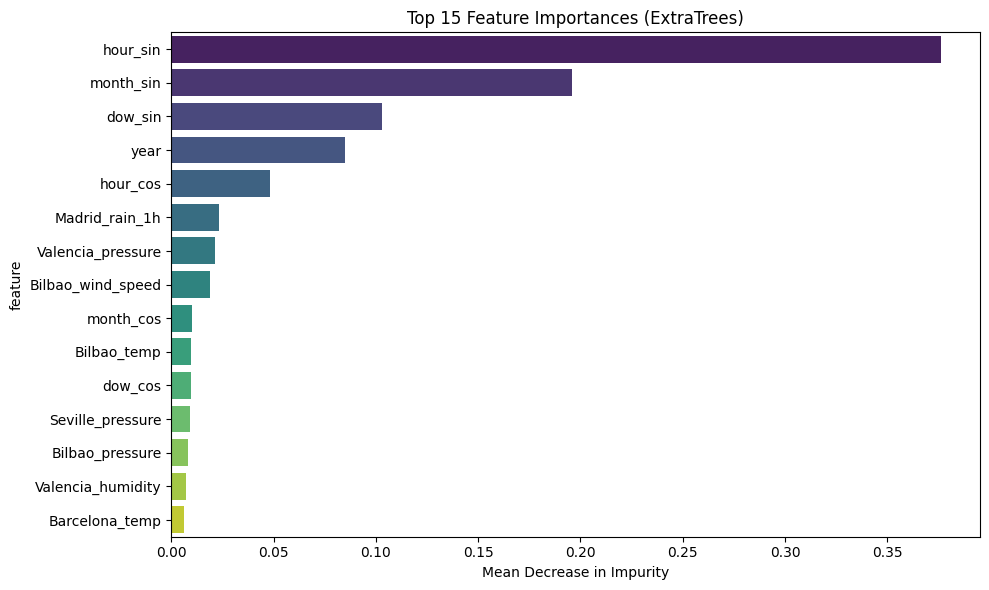


=== SHAP ANALYSIS ===
Generating SHAP summary plot...


c:\Users\lackerman008\Electricity Shortfall Challenge\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


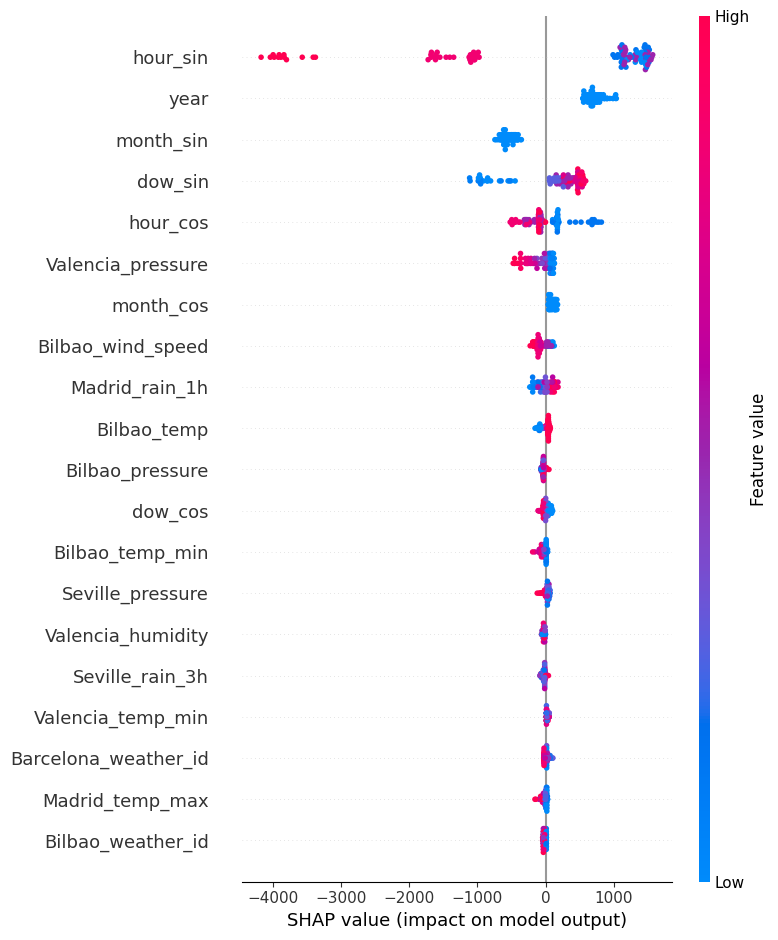

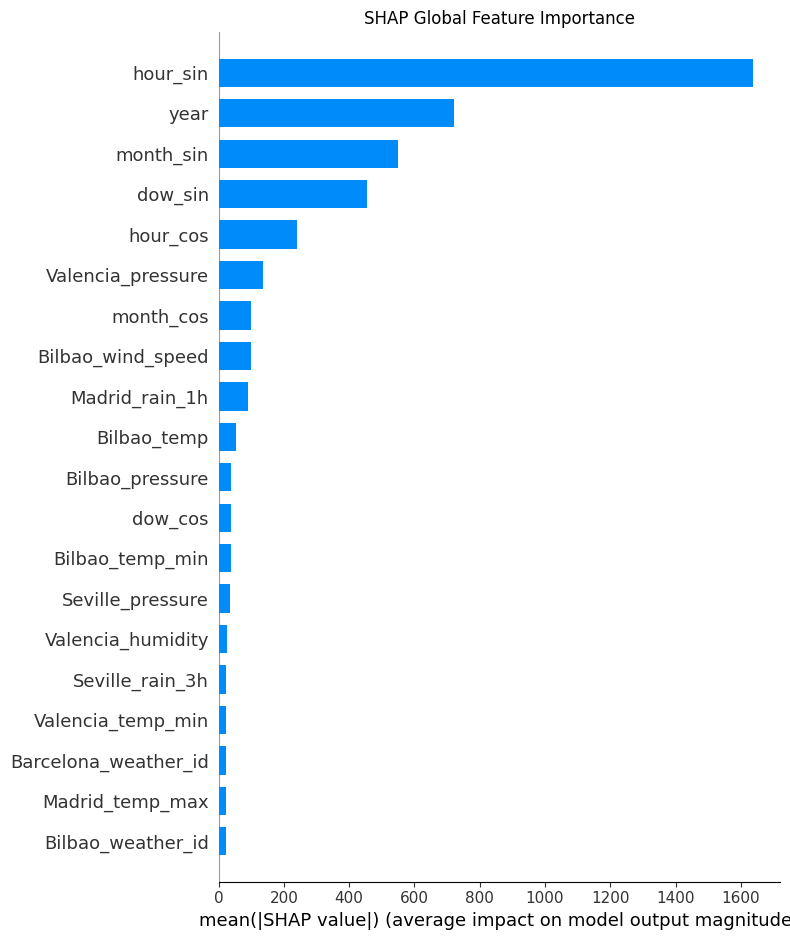

Most important features:
               feature  importance
46           hour_sin    0.376521
50          month_sin    0.196083
48            dow_sin    0.102928
52               year    0.084693
47           hour_cos    0.048433
34     Madrid_rain_1h    0.023496
0   Valencia_pressure    0.021556
1   Bilbao_wind_speed    0.019006
51          month_cos    0.010226
32        Bilbao_temp    0.009582


In [14]:
# Assuming:
# - pipeline: your trained pipeline object
# - test_df: your test DataFrame (without target)

results = analyze_weather_pipeline_no_target(pipeline, test_df, feature_names_transformed=preprocessor.named_steps['preprocessor'].get_feature_names_out(train_df.columns))

# Optional: save or inspect top features
top_features = results['feature_importance'].head(10)
print("Most important features:\n", top_features)

# Access SHAP values
shap_values = results['shap_values']